In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [27]:
import warnings; 
warnings.simplefilter('ignore')

In [3]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)


3.3.3
0.24.2
1.19.4
0.10.0
1.3.0


## Obtain and visualize data

In [4]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("global_temps.csv")
df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


<AxesSubplot:>

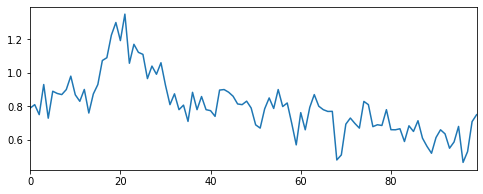

In [5]:
df.Mean[:100].plot()

## Exercise: what is wrong with the data and plot above? How can we fix this?

In [6]:
 df = df.pivot(index='Date', columns='Source', values='Mean')

In [7]:
df.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


/Users/joepauly/Documents/Projects/Notes/venv/lib/python3.7/site-packages/pandas/plotting/_core.py:396: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date'>

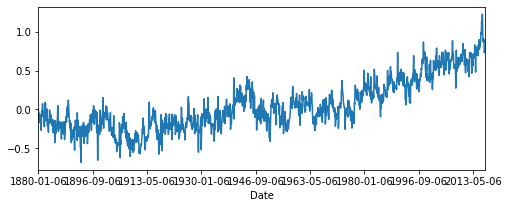

In [8]:
df.GCAG.plot()

In [9]:
type(df.index)

pandas.core.indexes.base.Index

## Exercise: how can we make the index more time aware?

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='Date'>

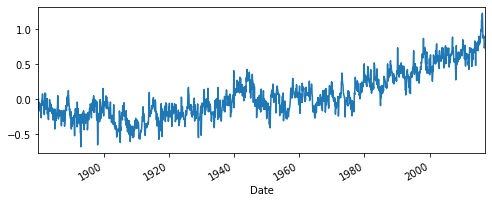

In [12]:
df.GCAG.plot()

In [13]:
df['1880']

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


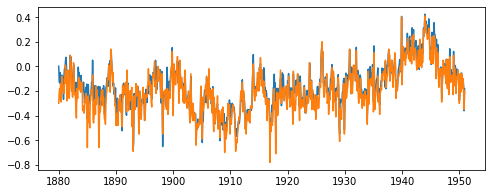

In [14]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])

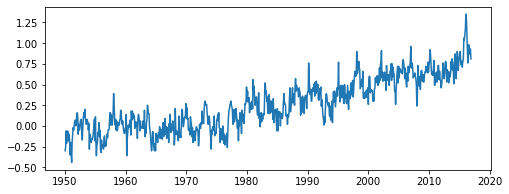

In [15]:
plt.plot(df['1950':][['GISTEMP']])

## Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

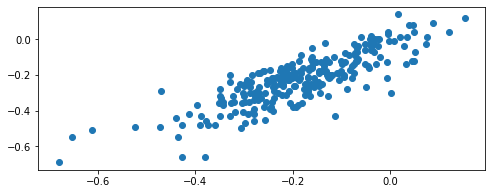

In [16]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])

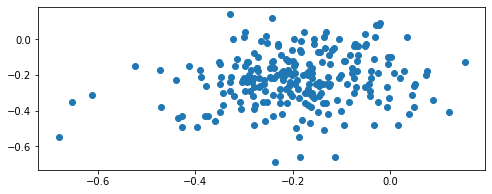

In [17]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])

In [18]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

(0.1546405732961276, 0.01650223473095511)

In [19]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [20]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [21]:
min(df.index)

Timestamp('1880-01-06 00:00:00')

In [22]:
max(df.index)

Timestamp('2016-12-06 00:00:00')

## Unobserved component model

In [23]:
train = df['1960':]

### model parameters

In [24]:
# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}


### fitting a model

In [28]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()

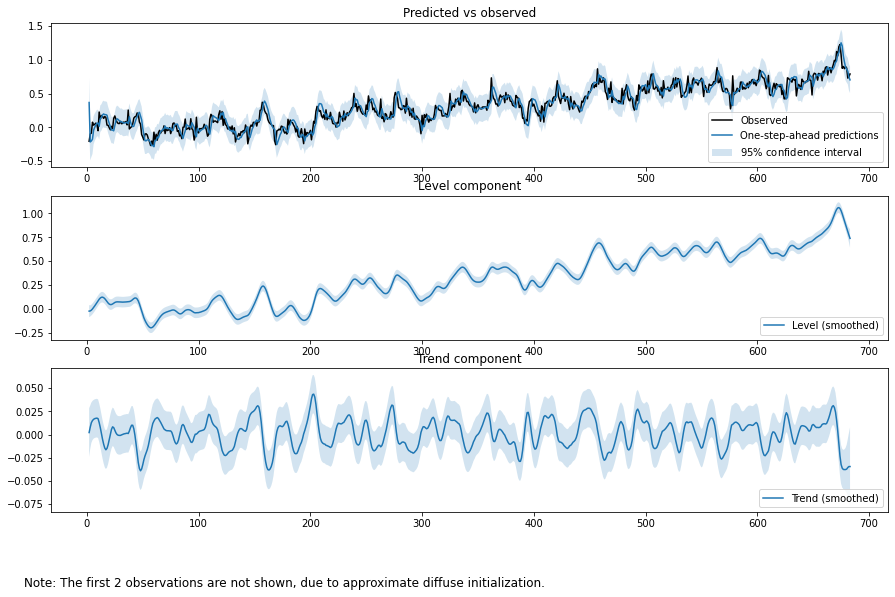

In [29]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

## Plotting predictions

In [30]:
# Perform rolling prediction and multistep forecast
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

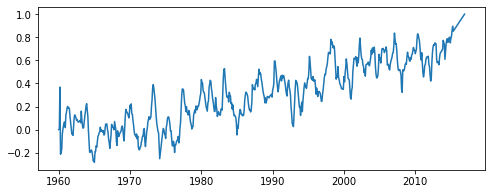

In [31]:
plt.plot(predict)

#### NOTE
Notice, the 20 montsh forecasted at the end are dynamic. They only take the previous timestemp (forecasted) as an input, so it's a linear projection. ARIMA will take better account of past error.

This is well explained with the following plots.

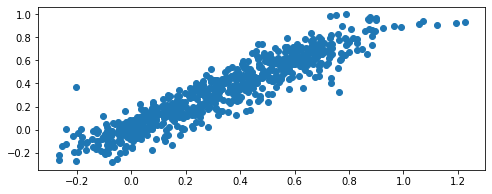

In [32]:
plt.scatter(train['GCAG'], predict)

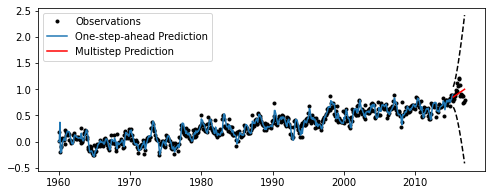

In [33]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

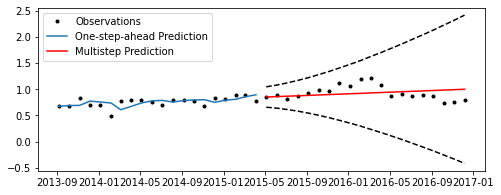

In [34]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

## Exercise: consider adding a seasonal term for 12 periods for the model fit above. Does this improve the fit of the model?

In [35]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

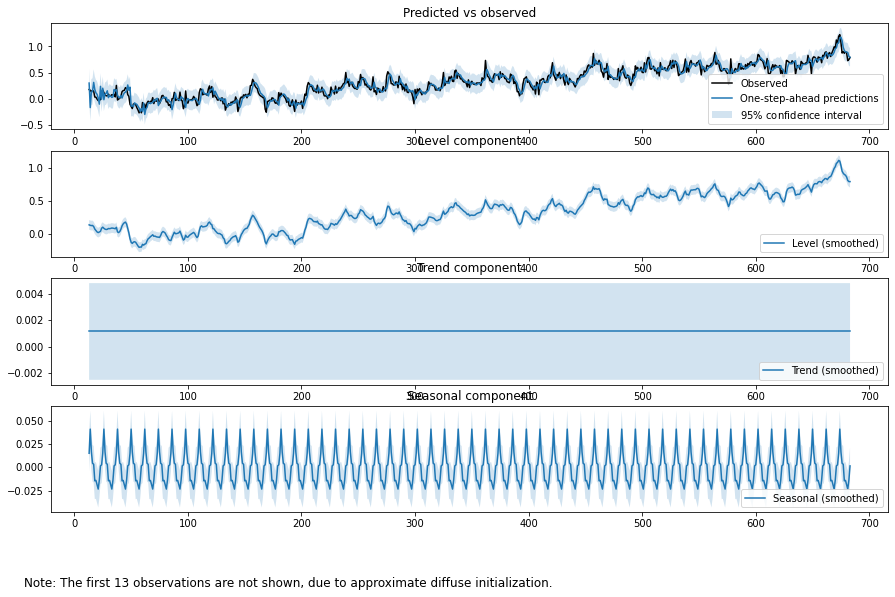

In [36]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));

### NOTE 

We see very little use in the Trend Component, so we can drop it in the next model

## How does this compare to the original model?

In [37]:
pearsonr(gcag_res.predict(), train['GCAG'])

(0.9376554633519587, 3.16460221e-315)

In [38]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

0.07721215185716095

In [39]:
np.mean(np.abs(res.predict() - train['GCAG']))

0.0720338014474474

## Explore the seasonality more

In [40]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

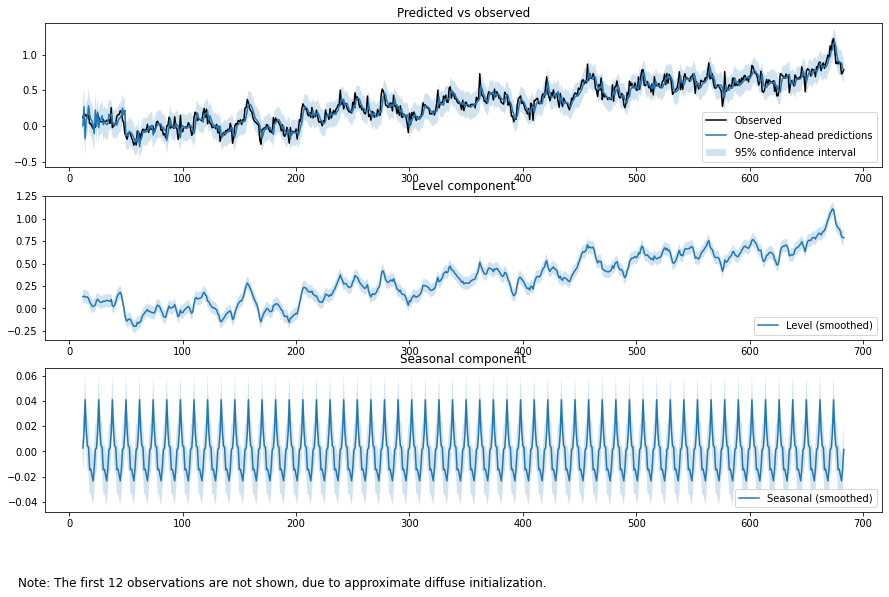

In [41]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

### NOTE

See here that a seasonal component worked very well with this data. This is different than a cycle component
- Cycles follow general sine wave and then try and to fit the changing amplitude and frequency of the waves
- Seasons have set intervals

In [42]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157731548929354

<AxesSubplot:xlabel='Date'>

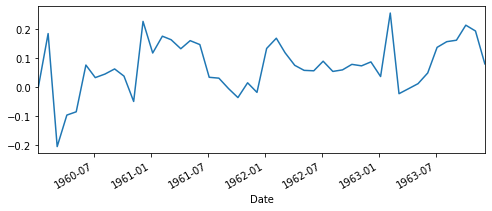

In [43]:
train[:48].GCAG.plot()

## Exercise: a common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

### Consider correlation

In [44]:
pearsonr(ll_level_res.predict(), train['GCAG'])

(0.9450048221609717, 0.0)

In [45]:
pearsonr(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

(0.9403611903118237, 4.01e-321)

### What about mean absolute error?

In [46]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157731548929354

In [47]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))

0.3475446559297218

### NOTE


Marginal improvement from original model in terms of accuracy

Significant improvement from original model in terms of MAE

So, need to make decision for yourself on whether it's useful to use more complex model